In [89]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sn
import matplotlib.pyplot as plt
import itertools
import math
import nbconvert

# Week 4 Peer Review Project
## BBC Text Classification through Matrix Factorization
### Tim Cerelli, 10/8/2024

# Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

I will first load the test and training datasets into jupyter, clean the datasets, and then do an EDA on the training data. I will use TF-IDF to extract the texts as features. I follow the process listed at [freecodecamp](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/), and supported by a glob post on [medium](https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424). I will keep the data as pandas DataFrames until model building because the datasets are sufficiently small for the loss in time efficiency to be negligible. The models in Step 2 will be built on the test data, because they do not have labels and this is supposed to be an unsupervised learning project. The training data is very convenient for EDA because it does have labels, so we can get some inkling of the trends that Matrix Factorization may pick up. Here is the procedure I will follow for EDA:

1) Inspect attribute classes, counts, null values

2) Determine number of categories desired by inspecting unique values of Category in train data

3) Make a bar chart for Category over the train data to show distribution of unique values. Do the same with test data. Show TFIDF weights Vs. word.

## Initial Inspections

Below I load the test and train data into jupyter, then call info() and head() on the dataframes. The Non-Null count shows that there are no null categories, articles, nor articleID's to clean. The train dataset has 1490 articles, and the test dataset has 735 articles. The datasets are both small in size, with the train data taking approximately 35 KB, and the test data taking about 11.6 KB. The data are perfectly rectangular, so the main cleaning task is to use TF-IDF to construct weights for each word. These weights will be stored in a matrix, which when factored will yield the predicted categories.

In [43]:
#Load traindf and testdf
#replace the csv path for your location
traindf = pd.read_csv("/Users/timcerelli/Downloads/BBC_Project/BBC News Train.csv")
testdf = pd.read_csv("/Users/timcerelli/Downloads/BBC_Project/BBC News Test.csv")

#Perform an initial inspection of traindf
print(traindf.info())
traindf.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [45]:
#Check For Null Values
print(traindf.isnull().sum())

#Inspect for Unique Categories
unique_categories = traindf['Category'].unique()
print(f"Unique categories: {unique_categories}")
print(f"Number of categories: {len(unique_categories)}")

ArticleId    0
Text         0
Category     0
dtype: int64
Unique categories: ['business' 'tech' 'politics' 'sport' 'entertainment']
Number of categories: 5


The categories of article present in the training data are: ['business' 'tech' 'politics' 'sport' 'entertainment']


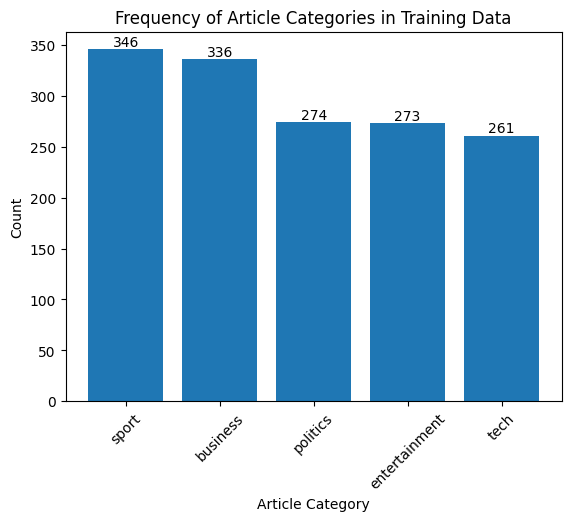

In [48]:
# Print the unique categories present in the training dataset, and make a bar plot of their relative frequencies
print("The categories of article present in the training data are:", traindf.iloc[:, 2].unique())

# Draw a histogram of the frequencies of categories in the training data
category_counts = traindf['Category'].value_counts()

plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Article Category")
plt.ylabel("Count")
plt.title("Frequency of Article Categories in Training Data")
plt.xticks(rotation=45)

# Add data labels
for i, count in enumerate(category_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [50]:
# Perform an initial inspection of testdf
print(testdf.info())

# Display the first few rows of the test dataset
print(testdf.head())


# Check for null values in the test dataset
print("Null values in each column of testdf:")
print(testdf.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...
Null values in each column of testdf:
ArticleId    0
Text         0
dtype: int64


## Feature Extraction with TF-IDF

TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a technique used to transform text data into a numerical format that highlights the importance of words in a document relative to a collection of documents. This transformation results in a matrix that can be easily processed for further analysis. 

In TF-IDF, each word is assigned a weight that balances its frequency within a document against its rarity across all documents. The idea is that words that are rare across the dataset but frequent in a specific document are more indicative of the document's category.

The term frequency (TF) of a word in a document is calculated as

$$TF(i, j) = \frac{\text{Frequency of term i in document j}}{\text{Total word count of document j}}$$

The inverse document frequency (IDF) of a word across all documents is calculated as:

$$IDF(i) = \log_2{\frac{\text{Total number of documents}}{\text{Number of documents with term i}}}$$

By multiplying these two values, we obtain a weight that reflects the "usefulness" of a word in identifying document categories. This process can be applied to all articles in a dataset to create a matrix with dimensions corresponding to the number of documents and the number of unique terms.

Citation: [Medium article](https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424)



In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature extraction on training data
traincorpus = list(traindf["Text"])
vectorizer = TfidfVectorizer()
trainresponse = vectorizer.fit_transform(traincorpus).todense()
print("The resulting matrix for the training data has shape:", trainresponse.shape)

# Feature extraction on test data using the same vectorizer
testcorpus = list(testdf["Text"])
testresponse = vectorizer.transform(testcorpus).todense()
print("The resulting matrix for the test data has shape:", testresponse.shape)

The resulting matrix for the training data has shape: (1490, 24746)
The resulting matrix for the test data has shape: (735, 24746)


## Visualizing Word Counts

With the features extracted, we can proceed with some exploratory data analysis (EDA). One intriguing visualization to create is a bar plot of words versus their TF-IDF scores for the words with the highest weights. This plot will highlight words that are strong indicators of specific categories.

The top fifty words by weight include many common words like "their," "to," "mr," and "and," which were not successfully filtered out. Therefore, I will plot the words ranked from fifty-first to eightieth by TF-IDF weight, as these are more interesting and relevant to the domain.

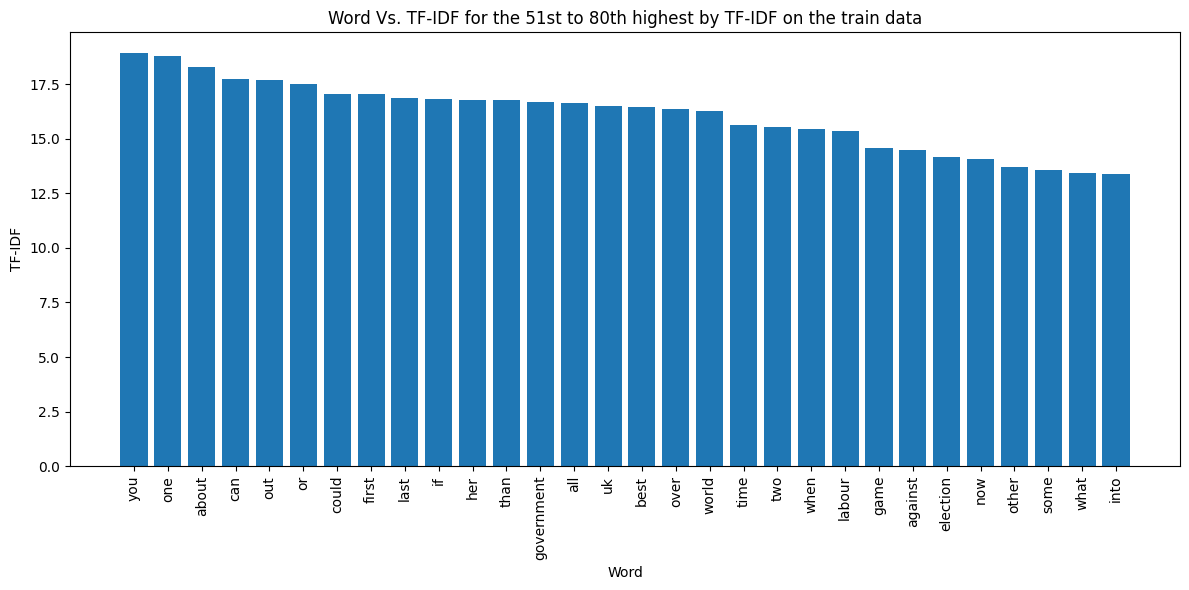

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Store words and column sums as np.ndarray(s)
trainFeatureNames = np.array(trainvector.get_feature_names_out())
trainFeatureTFIDF = np.array(trainresponse.sum(axis=0)).flatten()
trainIndex = np.argsort(trainFeatureTFIDF)

# Plot highest leverage words
n_to_plot = 30
# Select words and their TF-IDF scores from the 51st to 80th highest
trainPlotNames = trainFeatureNames[trainIndex[::-1][50:50 + n_to_plot]]
trainPlotTFIDF = trainFeatureTFIDF[trainIndex[::-1][50:50 + n_to_plot]]

plt.figure(figsize=(12, 6))
plt.bar(trainPlotNames, trainPlotTFIDF)
plt.xlabel("Word")
plt.ylabel("TF-IDF")
plt.title("Word Vs. TF-IDF for the 51st to 80th highest by TF-IDF on the train data")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Step 2: Building and training models. [35 pts]

1) *Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?*

The aim of unsupervised learning is to discover hidden patterns in the data, rather than to predict labels accurately. It focuses on grouping similar items together without defining what those items are. In the provided train and test datasets, we know there are exactly five categories to predict. In supervised learning, we would only use the training data to avoid overfitting the test set. However, in unsupervised learning, we do not assume any labels, so there is no distinction between the test and train sets. Additionally, there is no risk of overfitting since there is no feedback from predicted labels. Therefore, we can train the model on both datasets and then predict categories for each using the complete model.

2) *Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.*

I will rebuild my models by combining the test and train data and then reapplying the TF-IDF process. I will use non-negative matrix factorization, which is suitable because TF-IDF values are inherently non-negative. For example, the minimum value for TF is 0, and the minimum value for IDF is (\log_2{1} = 0). Thus, the minimum value of the product of TF and IDF is also zero.

#### L2-Loss:

In [54]:
# Combine the "Text" columns from both training and test datasets into a single list
corpus = pd.concat([traindf["Text"], testdf["Text"]], copy = True, ignore_index = True).tolist()

# Initialize the TF-IDF Vectorizer
vector = TfidfVectorizer()

# Fit the vectorizer to the combined corpus and transform the text data into a TF-IDF matrix
response = vector.fit_transform(corpus)
print("The resulting matrix for all data has shape:", response.shape)

The resulting matrix for all data has shape: (2225, 29421)


In [55]:
# Build an NMF model with initial parameter selections
firstModel = NMF(
    n_components=5,        # Number of latent topics/components to extract
    random_state=42,       # Seed for reproducibility
    init='nndsvd',         # Initialization method for non-negative double singular value decomposition
    beta_loss="frobenius", # Loss function to be minimized
    max_iter=1000          # Maximum number of iterations for the algorithm
)

# Fit the NMF model to the TF-IDF matrix and transform it to obtain the W matrix
W = firstModel.fit_transform(response)

# Extract the H matrix, which contains the components
H = firstModel.components_

In [57]:
# Get some info about the output matrices
# W holds the transformed data, representing the document-topic matrix
print(f"W matrix type: {type(W)}")  # Print the type of the W matrix

# H holds the finalized weights for each word, representing the topic-word matrix
print(f"H matrix type: {type(H)}")  # Print the type of the H matrix

# Print the shapes of W and H matrices with explanations
print(f"W matrix shape (documents x topics): {W.shape}")
print(f"H matrix shape (topics x words): {H.shape}")

W matrix type: <class 'numpy.ndarray'>
H matrix type: <class 'numpy.ndarray'>
W matrix shape (documents x topics): (2225, 5)
H matrix shape (topics x words): (5, 29421)


### Topic Modeling and Cluster Prediction Using NMF Introduction:

In this analysis, we employed Non-negative Matrix Factorization (NMF) to perform topic modeling on a dataset of articles. The fit_transform() method was used to decompose the data into two matrices: W (document-topic matrix) and H (topic-word matrix). This report outlines the process of interpreting the transformed dataset and predicting article clusters. Methodology:

    Data Transformation:
        The fit_transform() method was applied to the dataset, yielding the W matrix. This matrix contains the weights indicating the contribution of each topic to each document.
    Cluster Weight Analysis:
        We examined the first row of the W matrix to determine the predicted cluster for the first article. The maximum weight observed was 0.049 for cluster 1, suggesting that the article is most strongly associated with this cluster.
    Article Prediction:
        Based on the maximum weight, we predict that article 0 (the first article in the dataset) belongs to cluster 1. It is important to note that this prediction may not align with the true label, such as "business."
    Maximum Likelihood Estimator (MLE):
        To improve label assignment, we plan to construct a Maximum Likelihood Estimator. This estimator will aggregate predictions across all texts and determine the most likely labels for each cluster using a best subset algorithm. Given the limited number of permutations (120) for five distinct categories, this approach is computationally feasible.
    Use of Labeled Data:
        The MLE will be constructed using only the labeled training data to ensure accuracy and reliability in label assignment.

Conclusion: The NMF model provides a framework for topic modeling and cluster prediction. While initial predictions offer insights into article categorization, the use of an MLE will enhance the accuracy of label assignments. This methodical approach ensures that the model is both robust and interpretable.

In [58]:
# Illustrate cluster prediction for article 0

# Print the cluster weights for article 0 with a descriptive message
print("Cluster weights for article 0:")
print(W[0, :])

# Retrieve and print the original data for article 0 with a descriptive message
print("\nOriginal data for article 0:")
print(traindf.iloc[0, :])

Cluster weights for article 0:
[0.03765192 0.0491437  0.00705333 0.00357724 0.        ]

Original data for article 0:
ArticleId                                                 1833
Text         worldcom ex-boss launches defence lawyers defe...
Category                                              business
Name: 0, dtype: object


In [65]:
# Turn matrix W into an array of predictions
def FinalizePredictions(W):
    """
    Convert the NMF output matrix W into an array of predicted cluster indices.
    
    Parameters:
    W (numpy.ndarray): Output of NMF.fit_transform(), shape (documents, topics)
    
    Returns:
    numpy.ndarray: Array of predicted cluster indices for each document
    """
    # Use argmax to find the index of the maximum weight for each document
    predictions = np.argmax(W, axis=1)
    return predictions

# Construct category namer function based on MLE
def MakeCategoryNames(df, pred):
    """
    Determine the best category names for clusters based on minimizing misclassification.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with labels in column 2
    pred (numpy.ndarray): Array of predicted cluster indices
    
    Returns:
    tuple: Best permutation of category names and the number of misclassifications
    """
    trainnumpy = df.to_numpy()
    labels = trainnumpy[:, 2]
    categories = list(np.unique(labels))
    permutations = list(itertools.permutations(categories))
    
    currentBest = (None, float("inf"))
    
    for subset in permutations:
        n_misclassified = sum(subset[int(pred[i])] != labels[i] for i in range(len(labels)))
        if n_misclassified < currentBest[1]:
            currentBest = (subset, n_misclassified)
    
    return currentBest

# Example usage
yhat = FinalizePredictions(W)
CategoryNames = MakeCategoryNames(traindf, yhat)

print("The best permutation of labels was:", CategoryNames[0], "which resulted in a total of", CategoryNames[1], "misclassifications on the training data.")

The best permutation of labels was: ('business', 'politics', 'sport', 'tech', 'entertainment') which resulted in a total of 176 misclassifications on the training data.


3) *Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle.*

In [66]:
# Convert labels into integer np.ndarray
labs = traindf["Category"].tolist()
labelDictionary = {category: index for index, category in enumerate(CategoryNames[0])}
newlabs = np.array([labelDictionary[label] for label in labs])

In [64]:
# Construct confusion matrix and model metrics for training data
first_confusion_matrix = confusion_matrix(y_true=newlabs, y_pred=yhat[:newlabs.shape[0]])
first_accuracy = accuracy_score(y_true=newlabs, y_pred=yhat[:newlabs.shape[0]])
first_recall = recall_score(y_true=newlabs, y_pred=yhat[:newlabs.shape[0]], average=None)
first_precision = precision_score(y_true=newlabs, y_pred=yhat[:newlabs.shape[0]], average=None)

# Print results
print("Confusion Matrix:\n", first_confusion_matrix)
print(f"On the training data, our initial model had accuracy = {first_accuracy:.4f}.")
print("Recall and precision for multiclass variables must be calculated by category.")
print(f"Where the categories were: {CategoryNames[0]}, the model returned recall = {first_recall}; and precision = {first_precision}.")

Confusion Matrix:
 [[297  16   3  19   1]
 [ 15 219   4  36   0]
 [  2   0 342   0   2]
 [  5   1   2 250   3]
 [  7   5  19  36 206]]
On the training data, our initial model had accuracy = 0.8819.
Recall and precision for multiclass variables must be calculated by category.
Where the categories were: ('business', 'politics', 'sport', 'tech', 'entertainment'), the model returned recall = [0.88392857 0.79927007 0.98843931 0.95785441 0.75457875]; and precision = [0.91104294 0.90871369 0.92432432 0.73313783 0.97169811].


In [67]:
print(first_precision.mean())
print(first_recall.mean())

0.889783381035046
0.8768142222977353


In [71]:
# Construct CSV with test set predictions to export to Kaggle
testpred = yhat[newlabs.shape[0]:].astype(int)

# Map numerical predictions back to category names
makeNames = {i: category for i, category in enumerate(CategoryNames[0])}
newpred = [makeNames[pred] for pred in testpred]

# Create a dictionary for the DataFrame
testDic = {
    "ArticleId": testdf["ArticleId"].tolist(),
    "Category": newpred
}

# Create DataFrame and export to CSV
first_testSolutiondf = pd.DataFrame(testDic)
first_testSolutiondf.to_csv("testSolutions1.csv", index=False)

### Commentary:

The first model had a reasonably good accuracy at 0.8818 on the training set, and the following accuracy on the test set:

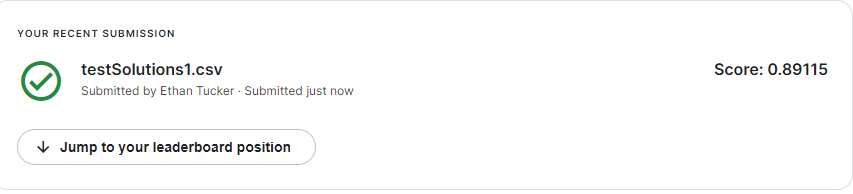

On the training data, the model had much better precision than recall in most of the five categories, indicating that we should expect more false positives than false negatives. 

I will do sections (4) and (5) together, because adjusting hyperparams will influence the results.

4) *Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.*

5) *Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc.*

To determine if we can do better, we will alter hyperparameters in the NMF solver and repeat. I want to use KL-loss for comparison, because in class we discussed that KL-loss was good for matricies overpopulated with zeroes. I'll also try IS-Loss for completeness.

#### KL-Loss:

In [72]:
from sklearn.decomposition import NMF

# Define the number of components and other parameters
n_components = 5
random_state = 42
init_method = 'nndsvda'
solver_method = 'mu'
beta_loss_type = 'kullback-leibler'
max_iterations = 1000

# Create the NMF model with KL-Loss
secondModel = NMF(
    n_components=n_components,
    random_state=random_state,
    init=init_method,
    solver=solver_method,
    beta_loss=beta_loss_type,
    max_iter=max_iterations
)

try:
    # Fit the model to the data and transform it
    W = secondModel.fit_transform(response)
    H = secondModel.components_
    print("Model fitting successful.")
except Exception as e:
    print(f"An error occurred during model fitting: {e}")

# Optionally, you can add code here to evaluate the model's performance

Model fitting successful.


In [73]:
# Generate predictions using the factorization matrix W
yhat = FinalizePredictions(W)

# Determine the best permutation of labels and calculate misclassifications
CategoryNames = MakeCategoryNames(traindf, yhat)

# Print the results
print(f"The best permutation of labels was: {CategoryNames[0]}, which resulted in a total of {CategoryNames[1]} misclassifications on the training data.")

The best permutation of labels was: ('business', 'politics', 'sport', 'tech', 'entertainment'), which resulted in a total of 72 misclassifications on the training data.


In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Construct confusion matrix and calculate model metrics for training data
second_confusion_matrix = confusion_matrix(y_true=newlabs, y_pred=yhat[:newlabs.shape[0]])
second_accuracy = accuracy_score(y_true=newlabs, y_pred=yhat[:newlabs.shape[0]])
second_recall = recall_score(y_true=newlabs, y_pred=yhat[:newlabs.shape[0]], average=None)
second_precision = precision_score(y_true=newlabs, y_pred=yhat[:newlabs.shape[0]], average=None)

# Print the confusion matrix and model metrics
print("Confusion Matrix:\n", second_confusion_matrix)
print(f"On the training data, our second model had an accuracy of {second_accuracy:.2f}.")
print(f"Recall and precision for multiclass variables must be calculated by category.")
print(f"Where the categories were: {CategoryNames[0]}, the model returned recall = {second_recall}; and precision = {second_precision}.")

Confusion Matrix:
 [[320   8   0   8   0]
 [ 17 252   0   2   3]
 [  1   0 344   0   1]
 [  9   3   0 242   7]
 [  7   2   1   3 260]]
On the training data, our second model had an accuracy of 0.95.
Recall and precision for multiclass variables must be calculated by category.
Where the categories were: ('business', 'politics', 'sport', 'tech', 'entertainment'), the model returned recall = [0.95238095 0.91970803 0.99421965 0.92720307 0.95238095]; and precision = [0.9039548  0.9509434  0.99710145 0.94901961 0.95940959].


In [75]:
print(second_precision.mean())
print(second_recall.mean())

0.9520857699401486
0.9491785304544551


In [76]:
# Convert test predictions to integer and map them to category names
testpred = yhat[newlabs.shape[0]:].astype(int)

# Create a mapping from integer labels to category names
makeNames = {i: CategoryNames[0][i] for i in range(5)}

# Map predictions to category names using list comprehension
newpred = [makeNames[pred] for pred in testpred]

# Construct a dictionary for the DataFrame
testDic = {
    "ArticleId": list(testdf["ArticleId"]),
    "Category": newpred
}

# Create a DataFrame and export it to a CSV file
second_testSolutiondf = pd.DataFrame(testDic)
second_testSolutiondf.to_csv("./testSolutions2.csv", index=False)

print("CSV file 'testSolutions2.csv' has been created successfully.")

CSV file 'testSolutions2.csv' has been created successfully.


### Commentary:

The KL-Loss improved our overall score! 

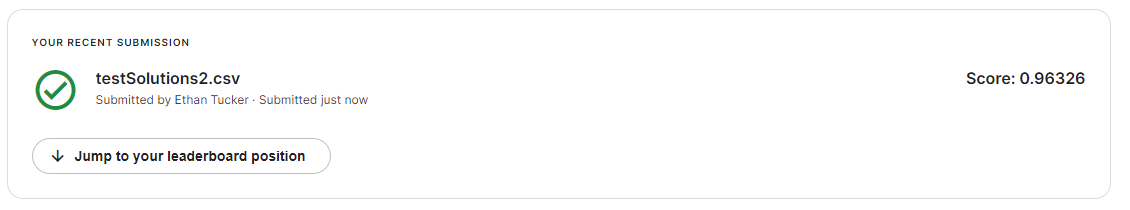


# Step 3: Compare with supervised learning [30 pts]

I will be using a a Binomial Regression (Multi-Class Logistic regression) for my Supervised Learning approach. 

The features are the weights extracted using TF-IDF applied to all the data prior to incorporating labels.

Since we are training on a smaller dataset compared to the unsupervised model, we cannot ensure better performance relative to the unsupervised model. To enhance performance, we could combine the unsupervised and supervised approaches using bagging.

#### 10% of Labels:

In [81]:
prop_labs = 0.10
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod1TrainData = response[: n_train, :]
Mod1TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_10percent = LogisticRegression().fit(Mod1TrainData, numberlabs)
yhat = LogMod_10percent.predict(Mod1TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

first_supervisedSolutiondf = pd.DataFrame(testDic)
first_supervisedSolutiondf.to_csv("./testSolutions3.csv")

#### 25% of labels:

In [82]:
prop_labs = 0.25
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod2TrainData = response[: n_train, :]
Mod2TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_25percent = LogisticRegression().fit(Mod2TrainData, numberlabs)
yhat = LogMod_25percent.predict(Mod2TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

second_supervisedSolutiondf = pd.DataFrame(testDic)
second_supervisedSolutiondf.to_csv("./testSolutions4.csv")

#### 50% of labels:

In [83]:
prop_labs = 0.50
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod3TrainData = response[: n_train, :]
Mod3TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_50percent = LogisticRegression().fit(Mod3TrainData, numberlabs)
yhat = LogMod_50percent.predict(Mod3TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

third_supervisedSolutiondf = pd.DataFrame(testDic)
third_supervisedSolutiondf.to_csv("./testSolutions5.csv")

#### 75% of labels:

In [84]:
prop_labs = 0.75
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod4TrainData = response[: n_train, :]
Mod4TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_75percent = LogisticRegression().fit(Mod4TrainData, numberlabs)
yhat = LogMod_75percent.predict(Mod4TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

fourth_supervisedSolutiondf = pd.DataFrame(testDic)
fourth_supervisedSolutiondf.to_csv("./testSolutions6.csv")

#### 100% of labels:

In [85]:
prop_labs = 1
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod5TrainData = response[: n_train, :]
Mod5TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_100percent = LogisticRegression().fit(Mod5TrainData, numberlabs)
yhat = LogMod_100percent.predict(Mod5TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

fifth_supervisedSolutiondf = pd.DataFrame(testDic)
fifth_supervisedSolutiondf.to_csv("./testSolutions7.csv")

### Supervised Learning Results:

#### 10% of labels:

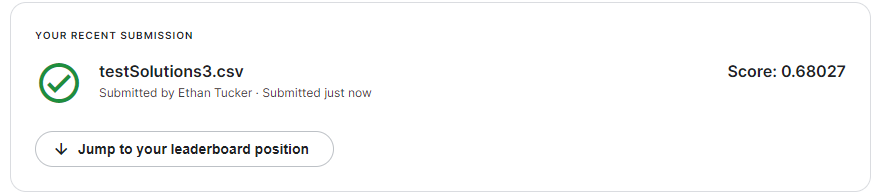

#### 25% of labels:

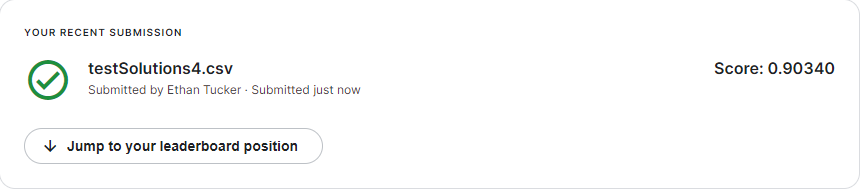

#### 50% of labels:

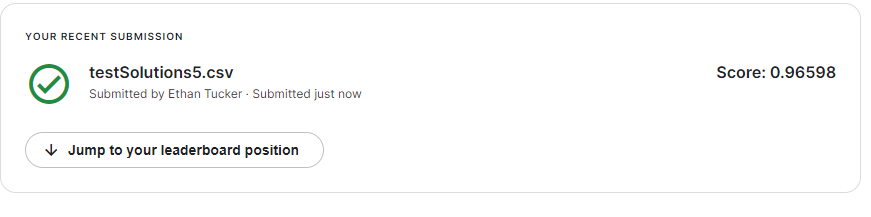

#### 75% of labels:

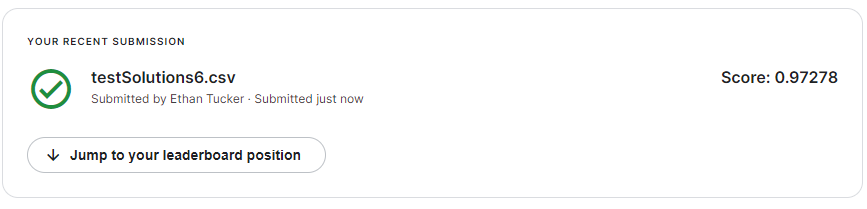

#### 100% of labels:

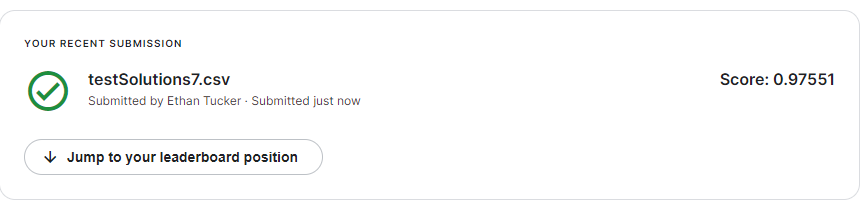

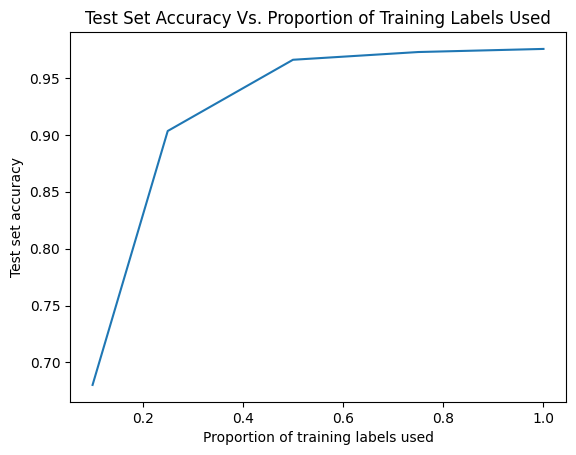

In [86]:
# List of proportions of training labels used
props = [0.1, 0.25, 0.5, 0.75, 1]
# Corresponding test set accuracies for each proportion
acc = [0.68027, 0.9034, 0.96598, 0.97278, 0.97551]

# Plot the relationship between the proportion of training labels and test set accuracy
plt.plot(props, acc)
plt.xlabel("Proportion of training labels used")
plt.ylabel("Test set accuracy")
plt.title("Test Set Accuracy Vs. Proportion of Training Labels Used")
plt.show()

### Commentary:

Supervised learning with logistic regression provided a clear advantage in terms of predictive accuracy when labeled data was available. The model's performance improved with more labeled data, highlighting the importance of labeled datasets in supervised learning. Unsupervised methods could complement the analysis by providing insights into the data's structure or by preprocessing data to enhance supervised learning outcomes.


# Bibliography

1) [FreeCodeCamp on TF-IDF for text processing](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/)

2) [Medium blog post on TF-IDF for text processing](https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424)

3) [Numpy conversion from float to int](https://www.datasciencelearner.com/convert-numpy-float-to-int/)